# Predicting Waiting Time in Banks Using Machine Learning

## Project Overview
The project's goal is to predict the waiting time of new customers in banks using machine learning methods. The primary objective is to forecast the waiting time based on the customer's arrival time and the current number of people in the queue.

## Key Stages

### 1. Data Collection and Processing
- Data was collected from three banks over four weeks.
- Each file contains information about customer arrival time, waiting time, and service time.

### 2. Data Exploration
- Key statistical indicators, such as average waiting time and the number of people in the queue, were calculated.
- Histograms and normal distributions were created to analyze probability density functions.

### 3. Data Preparation
- Input data (hours, minutes, day of the week) was encoded using mean encoding techniques for regression.
- The data was split into training and testing sets.
- Feature standardization was performed.

### 4. Theoretical Foundation: Queueing Theory (QMS)
- To better understand the waiting process, the concept of **Queueing Management Systems (QMS)** was used.
- QMS describes systems where customers (e.g., bank visitors) require service, and service facilities (e.g., tellers or managers) provide that service.
- The **M/M/1 model** was used, which assumes a single queue and one service facility with exponentially distributed inter-arrival and service times.
- Key model parameters:
  - **λ (lambda)** — the arrival rate (average number of customers per unit of time).
  - **μ (mu)** — the service rate (average number of customers served per unit of time).
  - **ρ (rho)** — the system's utilization factor, calculated as ρ = λ / μ.
- The model allows the estimation of the average waiting time in the queue and the number of customers in the system, which is then used in machine learning to enhance prediction accuracy.

### 5. Model Development
- A neural network with two hidden layers was developed and trained to predict waiting times.
- The model was trained over 500 epochs using the Keras and TensorFlow libraries.

### 6. Model Evaluation
- During training, the model demonstrated decreasing loss on the validation set, indicating improved prediction accuracy.

## Results
The model achieved minimal loss values on the test set, confirming its ability to accurately predict customer waiting times based on their arrival time and the current workload of the bank.


In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import os
import openpyxl as opx

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Input

# Loading Data from Dataset

The data was processed to record the arrival time, the time spent in the queue, and the service time of the client in the bank.

In [2]:
def file_len(fname, dayCounter):
    workbook = opx.load_workbook(fname, data_only=True)
    sheet = workbook.worksheets[dayCounter]
    return sheet.max_row

def file_read(path, numberOfRows, dayCounter):
    indexCounter = 0
    workbook = opx.load_workbook(path)
    sheet = workbook.worksheets[dayCounter]
    nColumns = 4  # Number of columns: hour, minutes, wait time, service time
    dataset = np.zeros(shape = (numberOfRows, nColumns))
    arrivalTimes = []
    flag = 1
    for row in sheet.iter_rows(min_row=2, max_row=numberOfRows+1, values_only=True):
        try:
            arrivalTime = row[1]  # Arrival time is in the second column
            arrivalHour = arrivalTime.hour
            arrivalMinute = arrivalTime.minute
            waitingMinutes = row[2]  # X1 in third
            serviceMinutes = row[3]  # X2 in fourth
        
            arrivalTimes.append(arrivalTime)
            dataset[indexCounter] = [arrivalHour, arrivalMinute, waitingMinutes, serviceMinutes]
            indexCounter += 1
        except Exception as e:
            print(f"Error processing row {indexCounter + 1}: {e}")
            if indexCounter > 0:
                dataset[indexCounter] = dataset[indexCounter - 1]
            indexCounter += 1
    return dataset, arrivalTimes

rootFilePath = './BankData/'
fullDataset = pd.DataFrame()

for bankCounter in range(1, 13):  # 12 files
    for dayCounter in range(5):  # 5 days in a week
        filename = 'Sber' + str(bankCounter)
        fullPath = rootFilePath + filename + '.xlsx'

        numberOfRows = file_len(fullPath, dayCounter) - 1
        print(f'Reading {filename}.xlsx. Day {dayCounter + 1}. The file contains {numberOfRows} rows')
        tempFeatures, tempArrivalTimes = file_read(fullPath, numberOfRows, dayCounter)
        
        dfTempFeatures = pd.DataFrame(np.array(tempFeatures), columns=['hour', 'minutes', 'waitingTime', 'serviceTime'])
        dfTempArrivalTimes = pd.DataFrame(np.array(tempArrivalTimes), columns=['arrivalTime'])

        timeLeavingTheQueue = []
        timeLeavingTheSystem = []
        for arrivalTimeCounter in range(numberOfRows):
            using_time = dfTempArrivalTimes.at[arrivalTimeCounter, 'arrivalTime']
            using_minute = dfTempFeatures.at[arrivalTimeCounter, 'waitingTime']
            using_minute_service = dfTempFeatures.at[arrivalTimeCounter, 'serviceTime']
            
            leaving_time_minute_step1 = using_time.minute + using_minute
            leaving_time_hour_step1 = using_time.hour
            if leaving_time_minute_step1 >= 60:
                leaving_time_minute_step1 = leaving_time_minute_step1 - 60
                leaving_time_hour_step1 = leaving_time_hour_step1 + 1
            leaving_time_minute = 0
            leaving_time_hour = 0
            if type(leaving_time_minute_step1) == int:
                leaving_time_minute = leaving_time_minute_step1
            else:
                leaving_time_minute = leaving_time_minute_step1.astype(int)

            if type(leaving_time_hour_step1) == int:
                leaving_time_hour = leaving_time_hour_step1
            else:
                leaving_time_hour = leaving_time_hour_step1.astype(int)
            
            leaving_the_system_time_minute_step1 = leaving_time_minute + using_minute_service
            leaving_the_system_time_hour = leaving_time_hour
            
            if leaving_the_system_time_minute_step1 >= 60:
                leaving_the_system_time_minute_step1 = leaving_the_system_time_minute_step1 - 60
                leaving_the_system_time_hour = leaving_the_system_time_hour + 1
            
            if type(leaving_the_system_time_minute_step1) == int:
                leaving_the_system_time_minute = leaving_the_system_time_minute_step1
            else:
                leaving_the_system_time_minute = leaving_the_system_time_minute_step1.astype(int)

            timeLeavingTheQueue.append(dt.time(hour = leaving_time_hour, minute = leaving_time_minute.astype(int)))
            timeLeavingTheSystem.append(dt.time(hour = leaving_the_system_time_hour, minute = leaving_the_system_time_minute))

        dftimeLeavingTheQueue = pd.DataFrame(np.array(timeLeavingTheQueue), columns=['timeLeavingTheQueue'])
        dftimeLeavingTheSystem = pd.DataFrame(np.array(timeLeavingTheSystem), columns=['timeLeavingTheSystem'])

        waitingPeople = np.zeros(numberOfRows)
        inSystemPeople = np.zeros(numberOfRows)
        servicePeople = np.zeros(numberOfRows)
        for i in range(numberOfRows):
            for j in range(i):
                if (dfTempArrivalTimes.at[i, 'arrivalTime'] < dftimeLeavingTheQueue.at[j, 'timeLeavingTheQueue']):
                    waitingPeople[i] += 1
                if (dfTempArrivalTimes.at[i, 'arrivalTime'] < dftimeLeavingTheSystem.at[j, 'timeLeavingTheSystem']):
                    inSystemPeople[i] += 1
            servicePeople[i] = inSystemPeople[i] - waitingPeople[i]
        dfWaitingPeople = pd.DataFrame(np.array(waitingPeople), columns=['waitingPeople'])
        dfInSystemPeople = pd.DataFrame(np.array(inSystemPeople), columns=['inSystemPeople'])
        dfServicePeople = pd.DataFrame(np.array(servicePeople), columns=['servicePeople'])

        dayOfWeek = np.zeros(numberOfRows)
        for i in range(numberOfRows):
            dayOfWeek[i] = dayCounter
        dfDayOfWeek = pd.DataFrame(np.array(dayOfWeek), columns=['dayOfWeek'])

        dfWaitingPeople['waitingPeople'] = dfWaitingPeople['waitingPeople'].astype(int)
        dfTempFeatures['hour'] = dfTempFeatures['hour'].astype(int)
        dfTempFeatures['minutes'] = dfTempFeatures['minutes'].astype(int)
        dfDayOfWeek['dayOfWeek'] = dfDayOfWeek['dayOfWeek'].astype(int)
        dfInSystemPeople['inSystemPeople'] = dfInSystemPeople['inSystemPeople'].astype(int)
        dfServicePeople['servicePeople'] = dfServicePeople['servicePeople'].astype(int)

        tempDataset = pd.concat([dfTempFeatures, dfWaitingPeople, dfServicePeople, dfInSystemPeople, dfDayOfWeek], axis=1)

        fullDataset = pd.concat([fullDataset, tempDataset], axis=0)
          
fullDataset = fullDataset.reset_index(drop = True)
print(f'Dataset: {fullDataset.shape[0]} rows and {fullDataset.shape[1]} columns')

Reading Sber1.xlsx. Day 1. The file contains 880 rows
Reading Sber1.xlsx. Day 2. The file contains 851 rows
Reading Sber1.xlsx. Day 3. The file contains 1020 rows
Reading Sber1.xlsx. Day 4. The file contains 802 rows
Reading Sber1.xlsx. Day 5. The file contains 522 rows
Reading Sber2.xlsx. Day 1. The file contains 989 rows
Reading Sber2.xlsx. Day 2. The file contains 684 rows
Reading Sber2.xlsx. Day 3. The file contains 548 rows
Reading Sber2.xlsx. Day 4. The file contains 1021 rows
Reading Sber2.xlsx. Day 5. The file contains 789 rows
Reading Sber3.xlsx. Day 1. The file contains 1000 rows
Reading Sber3.xlsx. Day 2. The file contains 990 rows
Reading Sber3.xlsx. Day 3. The file contains 1001 rows
Reading Sber3.xlsx. Day 4. The file contains 1051 rows
Reading Sber3.xlsx. Day 5. The file contains 982 rows
Reading Sber4.xlsx. Day 1. The file contains 857 rows
Reading Sber4.xlsx. Day 2. The file contains 981 rows
Reading Sber4.xlsx. Day 3. The file contains 1057 rows
Reading Sber4.xlsx. Da

In [3]:
fullDataset.head(50)

,hour,minutes,waitingTime,serviceTime,waitingPeople,servicePeople,inSystemPeople,dayOfWeek
0,10,0,11.0,28.0,0,0,0,0
1,10,0,13.0,25.0,1,0,1,0
2,10,0,14.0,26.0,2,0,2,0
3,10,0,9.0,26.0,3,0,3,0
4,10,0,14.0,23.0,4,0,4,0
5,10,0,10.0,26.0,5,0,5,0
6,10,0,9.0,27.0,6,0,6,0
7,10,1,10.0,27.0,7,0,7,0
8,10,1,11.0,26.0,8,0,8,0
9,10,1,12.0,24.0,9,0,9,0


In [4]:
fullDataset.describe()

,hour,minutes,waitingTime,serviceTime,waitingPeople,servicePeople,inSystemPeople,dayOfWeek
count,52636.000000,52636.000000,52636.000000,52636.000000,52636.000000,52636.000000,52636.000000,52636.000000
mean,12.684550,27.828444,13.453235,13.439512,28.995896,28.189167,57.185063,1.954214
std,2.154595,17.421315,6.052131,5.911448,17.810898,19.157396,28.201847,1.408787
min,10.000000,0.000000,3.004883,4.000488,0.000000,0.000000,0.000000,0.000000
25%,11.000000,13.000000,9.077013,8.740287,17.000000,15.000000,36.000000,1.000000
50%,12.000000,27.000000,12.063906,12.301431,25.000000,24.000000,53.000000,2.000000
75%,15.000000,43.000000,16.731613,17.114917,37.000000,38.000000,75.000000,3.000000
max,16.000000,59.000000,34.984741,35.999512,109.000000,134.000000,164.000000,4.000000


# Data Exploration

## Waiting time and number of people in the queue

In [5]:
n = 'undefined'  # Number of channels in the queuing system (QS)

numberOfBanks = 12
numberOfDays = 5
numberOfHours = 7
lamb = fullDataset.shape[0] / numberOfBanks / numberOfDays / numberOfHours  # Arrival rate of requests in the QS
print(f'Arrival rate in the QS: {lamb} requests/hour')

mu = lamb  # Service rate = arrival rate, considering that waiting time is given for each request.
# Otherwise, there's no other way to obtain this information.
print(f'Service rate: {mu} requests/hour (equal to the arrival rate since there is no information about requests leaving)')

ro = lamb / mu  # Load coefficient of the QS
print(f'Коэффициент загрузки СМО: {ro}')

m = 9999  # The number of places in the queue does not have significant meaning in this context.

pOtk = 0.0  # Probability of service rejection
print(f'Probability of service rejection: {pOtk}')

pObs = 1.0 - pOtk  # Probability of service
print(f'Probability of servicing an incoming request: {pObs}\n')

A = lamb * pObs  # Average number of requests serviced per unit of time (absolute throughput)
print(f'Average number of serviced requests: {A} requests/hour')

meanLSMO = fullDataset['inSystemPeople'].mean()  # Average number of requests in the QS
print(f'Average number of requests in the QS: {meanLSMO}')
medianLSMO = fullDataset['inSystemPeople'].median()
print(f'Median number of requests in the QS: {medianLSMO}')
stdLSMO = fullDataset['inSystemPeople'].std()
print(f'Standard deviation of the number of requests in the QS: {stdLSMO}\n')

meanWaiting = fullDataset['waitingPeople'].mean()  # Average number of requests in the queue
print(f'Average number of requests in the queue: {meanWaiting}')
medianWaiting = fullDataset['waitingPeople'].median()
print(f'Median number of requests in the queue: {medianWaiting}')
stdWaiting = fullDataset['waitingPeople'].std()
print(f'Standard deviation of the number of requests in the queue: {stdWaiting}\n')

meanChannels = fullDataset['servicePeople'].mean()  # Average number of channels occupied with servicing
print(f'Average number of channels occupied with servicing: {meanChannels}')
medianChannels = fullDataset['servicePeople'].median()
print(f'Median number of channels occupied with servicing: {medianChannels}')
stdChannels = fullDataset['servicePeople'].std()
print(f'Standard deviation of the number of channels occupied with servicing: {stdChannels}\n')

# Unable to calculate channel occupancy coefficient

# Unable to calculate the intensity of requests leaving the queue

myMean = fullDataset["waitingTime"].mean()
print(f'Average waiting time in the queue: {myMean} minutes')

myMedian = fullDataset["waitingTime"].median()
print(f'Median waiting time in the queue: {myMedian} minutes')

myStd = fullDataset["waitingTime"].std()
print(f'Standard deviation of waiting time in the queue: {myStd} minutes.\n')

Arrival rate in the QS: 125.32380952380952 requests/hour
Service rate: 125.32380952380952 requests/hour (equal to the arrival rate since there is no information about requests leaving)
Коэффициент загрузки СМО: 1.0
Probability of service rejection: 0.0
Probability of servicing an incoming request: 1.0

Average number of serviced requests: 125.32380952380952 requests/hour
Average number of requests in the QS: 57.18506345466981
Median number of requests in the QS: 53.0
Standard deviation of the number of requests in the QS: 28.201846894661625

Average number of requests in the queue: 28.995896344707045
Median number of requests in the queue: 25.0
Standard deviation of the number of requests in the queue: 17.810898386437785

Average number of channels occupied with servicing: 28.189167109962764
Median number of channels occupied with servicing: 24.0
Standard deviation of the number of channels occupied with servicing: 19.157396023994977

Average waiting time in the queue: 13.4532349449582

## Building a Histogram and Fitting a Normal Distribution

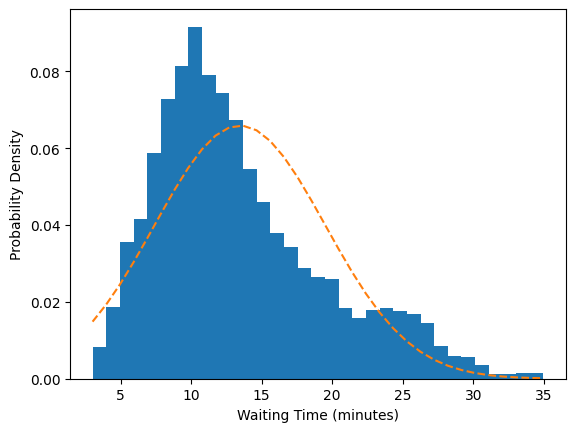

In [6]:
mean = fullDataset["waitingTime"].mean()  # Average waiting time in the queue
sigma = fullDataset["waitingTime"].std()  # Standard deviation of waiting time in the queue
x = fullDataset["waitingTime"]

num_bins = 33

fig, ax = plt.subplots()  # Create figure and axis objects for plotting

n, bins, patches = ax.hist(x, num_bins, density=1)  # Plot the probability density histogram

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mean))**2))

ax.plot(bins, y, '--')
ax.set_xlabel('Waiting Time (minutes)')
ax.set_ylabel('Probability Density')

os.makedirs('./plots', exist_ok=True)

plt.savefig('./plots/waitingTimeHistogram.pdf')

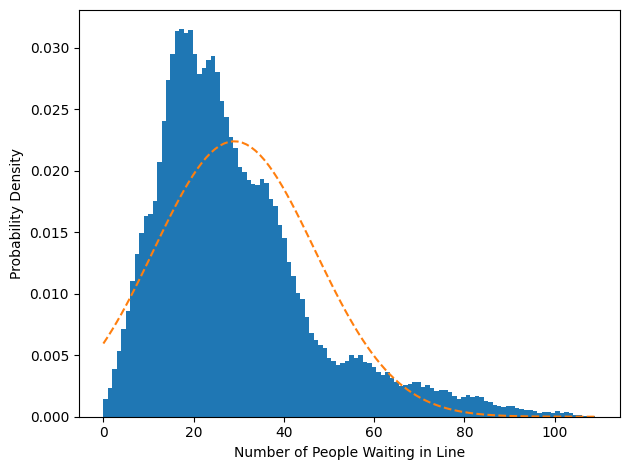

In [7]:
mean = fullDataset["waitingPeople"].mean()  # Average number of people waiting in line
sigma = fullDataset["waitingPeople"].std()  # Standard deviation of the number of people waiting in line
x = fullDataset["waitingPeople"]

num_bins = 110
fig, ax = plt.subplots()  # Create figure and axis objects for plotting

n, bins, patches = ax.hist(x, num_bins, density=1)  # Plot the probability density histogram (density = 1)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mean))**2))

ax.plot(bins, y, '--')
ax.set_xlabel('Number of People Waiting in Line')
ax.set_ylabel('Probability Density')

fig.tight_layout()
plt.savefig('./plots/waitingPeopleHistogram.pdf')

# Data Preparation for Neural Network Training

In [8]:
def mean_encoder_regression(input_vector, output_vector):
    assert len(input_vector) == len(output_vector)
    numberOfRows = len(input_vector)

    temp = pd.concat([input_vector, output_vector], axis=1)
    averages = temp.groupby(by=input_vector.name)[output_vector.name].agg(["mean", "count"])
    
    print(averages)
    return_vector = pd.DataFrame(0, index=np.arange(numberOfRows), columns=['feature'], dtype='float64')

    
    for i in range(numberOfRows):
        return_vector.iloc[i] = averages['mean'][input_vector.iloc[i]]
        
    return return_vector

In [9]:
workingCopyDataset = fullDataset
workingCopyDataset.drop(['serviceTime'], axis=1)

,hour,minutes,waitingTime,waitingPeople,servicePeople,inSystemPeople,dayOfWeek
0,10,0,11.000000,0,0,0,0
1,10,0,13.000000,1,0,1,0
2,10,0,14.000000,2,0,2,0
3,10,0,9.000000,3,0,3,0
4,10,0,14.000000,4,0,4,0
...,...,...,...,...,...,...,...
52631,16,57,12.865810,22,36,58,4
52632,16,58,8.851833,22,36,58,4
52633,16,59,8.364574,21,34,55,4
52634,16,59,11.140172,22,34,56,4


In [10]:
encoded_input_vector_hour = mean_encoder_regression(workingCopyDataset['hour'], workingCopyDataset['waitingTime'])
encoded_input_vector_hour.columns = ['hour']
encoded_input_vector_minutes = mean_encoder_regression(workingCopyDataset['minutes'], workingCopyDataset['waitingTime'])
encoded_input_vector_minutes.columns = ['minutes']
encoded_input_vector_dayOfWeek = mean_encoder_regression(workingCopyDataset['dayOfWeek'], workingCopyDataset['waitingTime'])
encoded_input_vector_dayOfWeek.columns = ['dayOfWeek']

X = pd.concat([encoded_input_vector_hour['hour'], encoded_input_vector_minutes['minutes'], pd.DataFrame(workingCopyDataset['waitingPeople']), encoded_input_vector_dayOfWeek['dayOfWeek']], axis=1)
y = workingCopyDataset['waitingTime']

           mean  count
hour                  
10    13.275502  11811
11    13.453828   8682
12    13.165451   6076
13    13.624776   5840
14    13.319474   6249
15    13.301795   5914
16    14.020238   8064
              mean  count
minutes                  
0        13.351721   1261
1        13.572363   1294
2        13.490881    881
3        13.543680    991
4        13.925891    929
5        13.283427   1138
6        13.342000    689
7        13.588167   1055
8        13.150438    823
9        13.554988    852
10       13.346630    851
11       13.532739   1190
12       13.593176    786
13       13.378263    876
14       13.673422    826
15       13.602620   1154
16       13.638419    860
17       13.749430   1232
18       13.742317    763
19       13.582883   1329
20       13.461401   1026
21       13.715065    885
22       14.247538    661
23       13.136453   1096
24       13.740649    800
25       13.275089   1131
26       13.819093    822
27       13.421109    977
28       13.8

In [11]:
X.describe()

,hour,minutes,waitingPeople,dayOfWeek
count,52636.000000,52636.000000,52636.000000,52636.000000
mean,13.453235,13.453235,28.995896,13.453235
std,0.271789,0.315181,17.810898,0.624008
min,13.165451,12.752886,0.000000,12.812132
25%,13.275502,13.223652,17.000000,12.891973
50%,13.319474,13.461401,25.000000,13.095238
75%,13.624776,13.638419,37.000000,14.076962
max,14.020238,14.251291,109.000000,14.283216


## Using sklearn for Machine Learning

In [12]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=42)
print(trainX.shape, trainy.shape)
print(testX.shape, testy.shape)

(42108, 4) (42108,)
(10528, 4) (10528,)


In [13]:
def scale_input(X, means, stds):
    return (X - means) / stds

def descale_input(X, means, stds):
    return (X * stds) + means

In [14]:
meansX = trainX.mean(axis=0)
stdsX = trainX.std(axis=0) + 1e-10

In [15]:
trainX_scaled = scale_input(trainX, meansX, stdsX)
testX_scaled = scale_input(testX, meansX, stdsX)

# Neural Network

## Creating a Deep Learning Model with Two Layers

In [16]:
inputVariables = 4

model = Sequential()
model.add(Input(shape=(inputVariables,)))
model.add(keras.layers.Dense(10, kernel_initializer='normal', activation='relu'))
model.add(keras.layers.Dense(10, activation='relu'))
model.add(keras.layers.Dense(1, activation='relu'))

model.summary()

model.compile(loss='mae', optimizer='adam')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              50 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171 (684.00 B)

 Trainable params: 171 (684.00 B)

 Non-trainable params: 0 (0.00 B)

## Neural Network Training

In [17]:
numberOfEpochs = 500
batchSize = 128
history = model.fit(trainX_scaled, trainy, epochs=numberOfEpochs, batch_size=batchSize, verbose=1, validation_split=0.2)

Epoch 1/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 12.3613 - val_loss: 4.8309
Epoch 2/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 4.0966 - val_loss: 3.7177
Epoch 3/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 3.7425 - val_loss: 3.6199
Epoch 4/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 3.6647 - val_loss: 3.5935
Epoch 5/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 3.6343 - val_loss: 3.5799
Epoch 6/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6214 - val_loss: 3.5741
Epoch 7/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6155 - val_loss: 3.5686
Epoch 8/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6216 - val_loss: 3.5604
Epoch 9/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 3.5954 - val_loss: 3.5612
Epoch 10/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 3.5927 - val_loss: 3.5519
Epoch 11/500
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 3.5934 - val_loss: 3.5536
Epoch 12/500
264/264 ━━━━━

## Neural Network Error

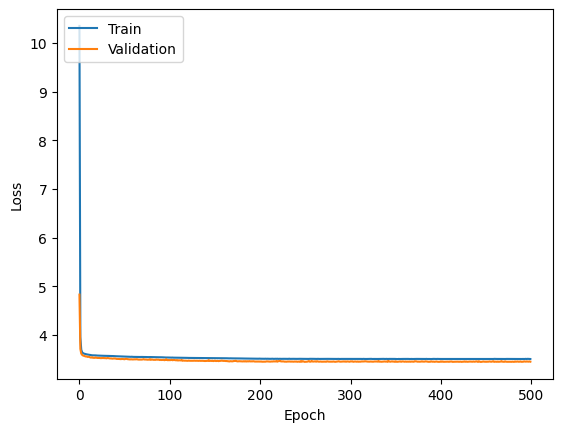

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.savefig('./plots/loss.pdf')

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step


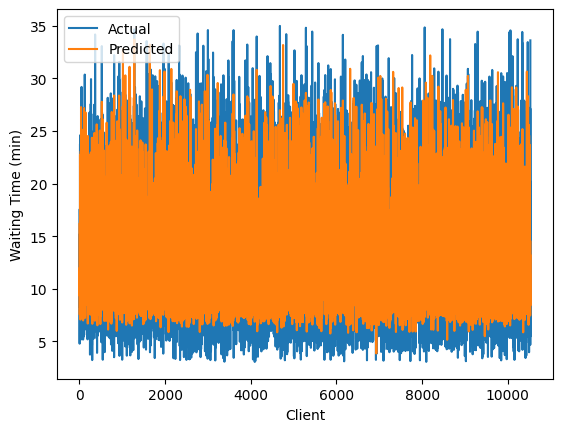

In [19]:
testy_pred = model.predict(testX_scaled)
myLength = len(testy_pred)
plt.plot(range(myLength), testy)
plt.plot(range(myLength), testy_pred)
plt.ylabel('Waiting Time (min)')
plt.xlabel('Client')
plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.savefig('./plots/realVsPredictedWaitingTimes.pdf')

## Comparison of Neural Network with Mean and Median Values

In [20]:
myMae = mean_absolute_error(testy, testy_pred)
print(f'Mean Absolute Error of the Neural Network: {myMae} minutes.')

Mean Absolute Error of the Neural Network: 3.4413656465171103 minutes.


In [21]:
myLength = len(testy_pred)
myFMean = np.mean(trainy)
myFMedian = np.median(trainy)
testyMean = testy_pred.copy()
testyMedian = testy_pred.copy()
for i in range(myLength):
    testyMean[i] = myFMean
    testyMedian[i] = myFMedian

In [22]:
meanValue = mean_absolute_error(testy, testyMean)
print(f'Mean Absolute Error using mean approximation: {meanValue} minutes.')

medianValue = mean_absolute_error(testy, testyMedian)
print(f'Mean Absolute Error using median approximation: {medianValue} minutes.')

Mean Absolute Error using mean approximation: 4.771244205909666 minutes.
Mean Absolute Error using median approximation: 4.634170441058564 minutes.
